## (1) Loading, classifying and visualizing the data

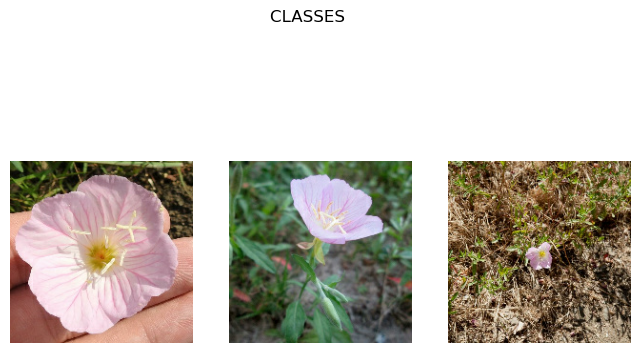

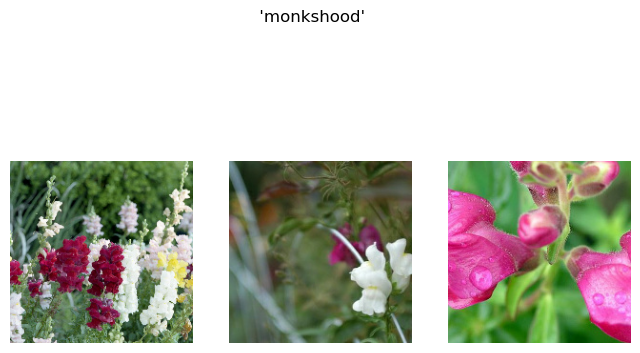

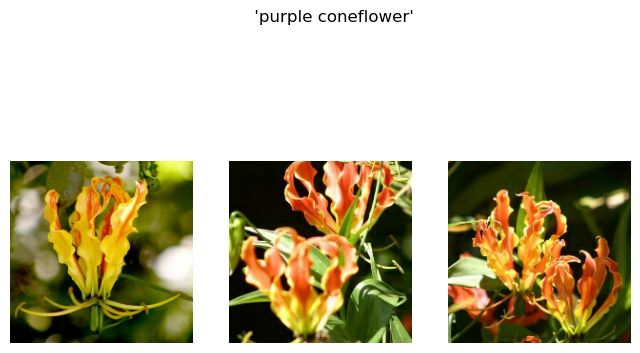

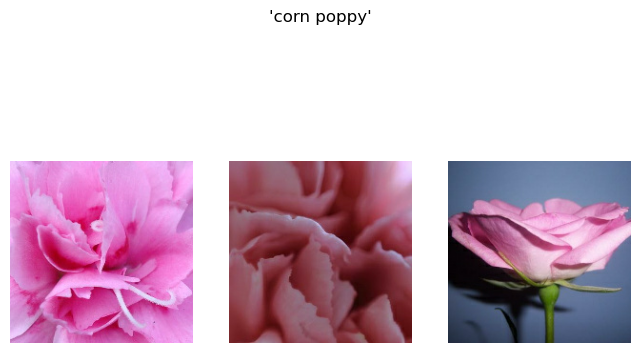

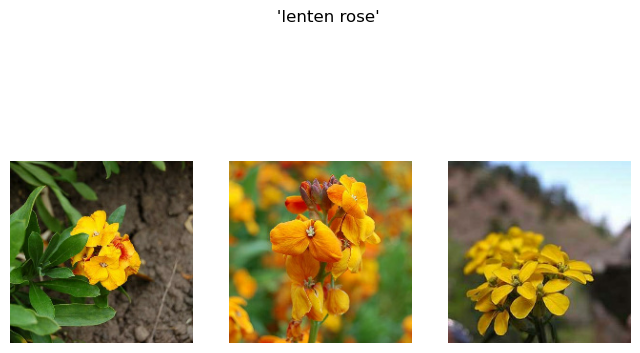

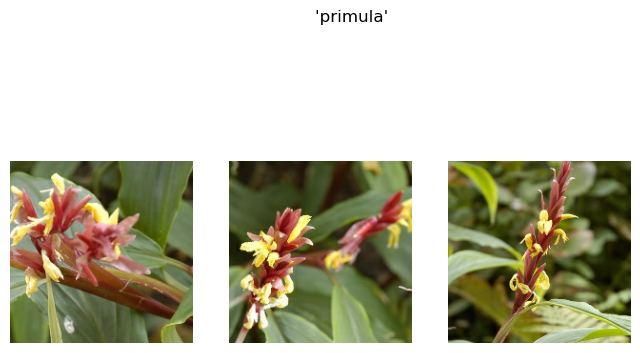

Class: CLASSES  - Number of Samples: 272
Class:   - Number of Samples: 85
Class: 'pink primrose' - Number of Samples: 20
Class:     'hard-leaved pocket orchid' - Number of Samples: 21
Class:  'canterbury bells' - Number of Samples: 703
Class:  'sweet pea' - Number of Samples: 87
Class:      'wild geranium' - Number of Samples: 18
Class:      'tiger lily' - Number of Samples: 105
Class:            'moon orchid' - Number of Samples: 87
Class:               'bird of paradise' - Number of Samples: 84
Class:  'monkshood' - Number of Samples: 136
Class:         'globe thistle' - Number of Samples: 43
Class:           - Number of Samples: 36
Class:  00 - 09
           'snapdragon' - Number of Samples: 263
Class:         - Number of Samples: 227
Class: colt's foot - Number of Samples: 21
Class:                'king protea' - Number of Samples: 55
Class:       'spear thistle' - Number of Samples: 50
Class:  'yellow iris' - Number of Samples: 90
Class:        'globe-flower' - Number of Samples: 

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import re

# Path to the dataset
DATA_PATH = "/kaggle/input/flower-classification/Data"

# Making a function to visualize images from some classes
def visualize_images_per_class():
    classes_to_visualize = [0, 10, 20, 30 , 45 , 60]  # Indices of classes to visualize
    num_images_per_class = 3  # Number of images to visualize for each class

    for class_idx in classes_to_visualize:
        class_folder = os.path.join(DATA_PATH, "train", str(class_idx))
        image_files = os.listdir(class_folder)[:num_images_per_class]
        class_name = f"Class {class_idx}"
        if class_idx < len(class_names):
            class_name = class_names[class_idx]
        images = []
        for image_file in image_files:
            image_path = os.path.join(class_folder, image_file)
            image = cv2.imread(image_path)  # Read the image using OpenCV
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(image)

        # Displaying images
        fig, axes = plt.subplots(1, num_images_per_class, figsize=(8, 4))
        fig.suptitle(class_name, fontsize=12, y=1.1)
        for i, ax in enumerate(axes):
            ax.imshow(images[i])
            ax.axis("off")
        plt.show()

# Reading the classes from the Classes.txt file
with open(os.path.join(DATA_PATH, "Classes.txt"), "r") as classes_file:
    classes_text = classes_file.read()

class_names = re.findall(r"[\w\s'-]+", classes_text)

# Calling the visualize_images_per_class() function
visualize_images_per_class()

# Counting the number of samples in each class
num_samples_per_class = {}
for class_idx in range(104):
    class_folder = os.path.join(DATA_PATH, "train", str(class_idx))
    num_samples = len(os.listdir(class_folder))
    class_name = f"Class {class_idx}"
    if class_idx < len(class_names):
        class_name = class_names[class_idx]
    num_samples_per_class[class_name] = num_samples

# Printing the number of samples in each class
for class_name, num_samples in num_samples_per_class.items():
    print(f"Class: {class_name} - Number of Samples: {num_samples}")


## (2) Splitting the Data and Applying Augmentation Techniques

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_folder = ImageFolder(root)

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, index):
        img_path, label = self.image_folder.imgs[index]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, label

# Defining the paths
DATA_PATH = '/kaggle/input/flower-classification/Data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')

# Defining image transformations with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomImageDataset(TRAIN_PATH, transform=train_transform)

# Splitting the training dataset into 90% for training and 10% for validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Creating data loaders for training and validation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Defining image transformations for test dataset (only scaling)
test_transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading the test dataset for model evaluation (no augmentation, only scaling)
test_dataset = CustomImageDataset(TEST_PATH, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## (3) Making the Models 
## (First, the Simple CNN model)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Defining the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 48 * 48, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Creating a SimpleCNN model
num_classes = 104
simplecnn_model = SimpleCNN(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simplecnn_model.to(device)

# Defining the loss function, optimizer, and learning rate 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simplecnn_model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
num_epochs = 15

for epoch in range(num_epochs):
    simplecnn_model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = simplecnn_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    # Evaluating the model on the validation set
    simplecnn_model.eval()

    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = simplecnn_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_data)
        val_acc = val_corrects.double() / len(val_data)

    print(f'Epoch: {epoch+1}/{num_epochs} ==> Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} '
          f'Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

# Saving the model after finish printing all the output
torch.save(simplecnn_model.state_dict(), 'simple_cnn.pth')


Epoch: 1/15 ==> Train Loss: 3.7964, Acc: 0.1217 Validation Loss: 3.4773, Acc: 0.1622
Epoch: 2/15 ==> Train Loss: 3.2135, Acc: 0.1953 Validation Loss: 3.1333, Acc: 0.2108
Epoch: 3/15 ==> Train Loss: 2.9324, Acc: 0.2525 Validation Loss: 3.0056, Acc: 0.2461
Epoch: 4/15 ==> Train Loss: 2.7284, Acc: 0.2933 Validation Loss: 2.8570, Acc: 0.2610
Epoch: 5/15 ==> Train Loss: 2.5341, Acc: 0.3338 Validation Loss: 2.8217, Acc: 0.2625
Epoch: 6/15 ==> Train Loss: 2.3400, Acc: 0.3762 Validation Loss: 2.7016, Acc: 0.3041
Epoch: 7/15 ==> Train Loss: 2.1795, Acc: 0.4181 Validation Loss: 2.6691, Acc: 0.3049
Epoch: 8/15 ==> Train Loss: 1.7690, Acc: 0.5330 Validation Loss: 2.4877, Acc: 0.3574
Epoch: 9/15 ==> Train Loss: 1.6616, Acc: 0.5520 Validation Loss: 2.4905, Acc: 0.3582
Epoch: 10/15 ==> Train Loss: 1.6140, Acc: 0.5685 Validation Loss: 2.5083, Acc: 0.3534
Epoch: 11/15 ==> Train Loss: 1.5672, Acc: 0.5821 Validation Loss: 2.5271, Acc: 0.3660
Epoch: 12/15 ==> Train Loss: 1.5300, Acc: 0.5897 Validation Los

## (The VGG model)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR

# Loading a pretrained VGG model
vgg_model = models.vgg16_bn(pretrained=True)

# Matching it with the number of classes in the dataset
num_classes = 104
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model.to(device)

# Defining the loss function, optimizer, and learning rate 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
num_epochs = 15

for epoch in range(num_epochs):
    vgg_model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    # Evaluating the model on the validation set
    vgg_model.eval()

    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vgg_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_data)
        val_acc = val_corrects.double() / len(val_data)

    print(f'Epoch: {epoch+1}/{num_epochs} ==> Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} '
          f'Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

# Saving the model after finishing printing all the output
torch.save(vgg_model.state_dict(), 'fine_tuned_vgg16.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s]  


Epoch: 1/15 ==> Train Loss: 2.2940, Acc: 0.4768 Validation Loss: 0.9577, Acc: 0.7508
Epoch: 2/15 ==> Train Loss: 0.8223, Acc: 0.7807 Validation Loss: 0.6707, Acc: 0.8190
Epoch: 3/15 ==> Train Loss: 0.5131, Acc: 0.8603 Validation Loss: 0.6144, Acc: 0.8401
Epoch: 4/15 ==> Train Loss: 0.3603, Acc: 0.8978 Validation Loss: 0.5153, Acc: 0.8629
Epoch: 5/15 ==> Train Loss: 0.2549, Acc: 0.9294 Validation Loss: 0.5572, Acc: 0.8558
Epoch: 6/15 ==> Train Loss: 0.2009, Acc: 0.9417 Validation Loss: 0.4946, Acc: 0.8770
Epoch: 7/15 ==> Train Loss: 0.1618, Acc: 0.9529 Validation Loss: 0.5094, Acc: 0.8754
Epoch: 8/15 ==> Train Loss: 0.1014, Acc: 0.9719 Validation Loss: 0.4970, Acc: 0.8770
Epoch: 9/15 ==> Train Loss: 0.0906, Acc: 0.9755 Validation Loss: 0.4705, Acc: 0.8824
Epoch: 10/15 ==> Train Loss: 0.0832, Acc: 0.9777 Validation Loss: 0.4680, Acc: 0.8840
Epoch: 11/15 ==> Train Loss: 0.0765, Acc: 0.9794 Validation Loss: 0.4797, Acc: 0.8871
Epoch: 12/15 ==> Train Loss: 0.0708, Acc: 0.9804 Validation Los

## (The GoogLeNet model)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR

# Loading a pretrained GoogLeNet model
googlenet_model = models.googlenet(pretrained=True)

# Matching it with the number of classes in the dataset
num_classes = 104
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet_model.to(device)

# Define the loss function, optimizer, and learning rate 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet_model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
num_epochs = 15

for epoch in range(num_epochs):
    googlenet_model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = googlenet_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    # Evaluating the model on the validation set
    googlenet_model.eval()

    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = googlenet_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_data)
        val_acc = val_corrects.double() / len(val_data)

    print(f'Epoch: {epoch+1}/{num_epochs} ==> Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} '
          f'Validation Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

# Saving the model after finishing printing all the output
torch.save(googlenet_model.state_dict(), 'fine_tuned_googlenet.pth')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 95.6MB/s]


Epoch: 1/15 ==> Train Loss: 3.5902, Acc: 0.2357 Validation Loss: 2.8925, Acc: 0.3582
Epoch: 2/15 ==> Train Loss: 2.4562, Acc: 0.4547 Validation Loss: 2.0752, Acc: 0.5439
Epoch: 3/15 ==> Train Loss: 1.8204, Acc: 0.6005 Validation Loss: 1.5930, Acc: 0.6418
Epoch: 4/15 ==> Train Loss: 1.4194, Acc: 0.6866 Validation Loss: 1.3243, Acc: 0.6873
Epoch: 5/15 ==> Train Loss: 1.1422, Acc: 0.7433 Validation Loss: 1.1119, Acc: 0.7359
Epoch: 6/15 ==> Train Loss: 0.9678, Acc: 0.7796 Validation Loss: 0.9788, Acc: 0.7539
Epoch: 7/15 ==> Train Loss: 0.8226, Acc: 0.8082 Validation Loss: 0.8741, Acc: 0.7719
Epoch: 8/15 ==> Train Loss: 0.7181, Acc: 0.8346 Validation Loss: 0.8563, Acc: 0.7829
Epoch: 9/15 ==> Train Loss: 0.6971, Acc: 0.8393 Validation Loss: 0.8707, Acc: 0.7766
Epoch: 10/15 ==> Train Loss: 0.6874, Acc: 0.8440 Validation Loss: 0.8507, Acc: 0.7782
Epoch: 11/15 ==> Train Loss: 0.6851, Acc: 0.8430 Validation Loss: 0.8408, Acc: 0.7861
Epoch: 12/15 ==> Train Loss: 0.6660, Acc: 0.8467 Validation Los

## (Ensembling)

In [6]:
# Making a function to make predictions with each model and create a ensemble
def ensemble_predict(data_loader):
    vgg_model.eval()
    googlenet_model.eval()

    ensemble_preds = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)

            # Make predictions with each model
            vgg_preds = vgg_model(inputs)
            googlenet_preds = googlenet_model(inputs)

            # Average the predictions
            ensemble_preds.append((vgg_preds + googlenet_preds) / 2)

    ensemble_preds = torch.cat(ensemble_preds, dim=0)
    return ensemble_preds

# Evaluating the ensemble model on the validation set
ensemble_preds = ensemble_predict(val_loader)

# Reshaping labels to match the shape of ensemble_preds
labels = torch.cat([labels for _, labels in val_loader], dim=0).to(device)

ensemble_loss = criterion(ensemble_preds, labels)
_, ensemble_preds = torch.max(ensemble_preds, 1)
ensemble_acc = torch.sum(ensemble_preds == labels.data) / len(labels)

print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} \t Validation Loss: {ensemble_loss:.4f}, Acc: {ensemble_acc:.4f}')


Train Loss: 0.6367, Acc: 0.8565 	 Validation Loss: 0.4151, Acc: 0.8911


## (4) Comparing Between The Performance Of The Models 
## (Accuracy, Macro F score)


In [7]:
import torch
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Making a function to evaluate the model on testing data
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

# Evaluating the SimpleCNN model
simplecnn_model.load_state_dict(torch.load('simple_cnn.pth'))
simplecnn_model.to(device)
y_true_simplecnn, y_pred_simplecnn = evaluate_model(simplecnn_model, test_loader)
accuracy_simplecnn = accuracy_score(y_true_simplecnn, y_pred_simplecnn)
f1_score_simplecnn = f1_score(y_true_simplecnn, y_pred_simplecnn, average='macro')

# Evaluating the VGG16 model
vgg_model.load_state_dict(torch.load('fine_tuned_vgg16.pth'))
vgg_model.to(device)
y_true_vgg, y_pred_vgg = evaluate_model(vgg_model, test_loader)
accuracy_vgg = accuracy_score(y_true_vgg, y_pred_vgg)
f1_score_vgg = f1_score(y_true_vgg, y_pred_vgg, average='macro')

# Evaluating the GoogLeNet model
googlenet_model.load_state_dict(torch.load('fine_tuned_googlenet.pth'))
googlenet_model.to(device)
y_true_googlenet, y_pred_googlenet = evaluate_model(googlenet_model, test_loader)
accuracy_googlenet = accuracy_score(y_true_googlenet, y_pred_googlenet)
f1_score_googlenet = f1_score(y_true_googlenet, y_pred_googlenet, average='macro')

# Printing the accuracy and macro F-score for each model
print("SimpleCNN:")
print("Accuracy:", accuracy_simplecnn)
print("Macro F-Score:", f1_score_simplecnn)
print()
print("VGG16:")
print("Accuracy:", accuracy_vgg)
print("Macro F-Score:", f1_score_vgg)
print()
print("GoogLeNet:")
print("Accuracy:", accuracy_googlenet)
print("Macro F-Score:", f1_score_googlenet)


SimpleCNN:
Accuracy: 0.3801185344827586
Macro F-Score: 0.302938558746528

VGG16:
Accuracy: 0.9022090517241379
Macro F-Score: 0.8900075282843005

GoogLeNet:
Accuracy: 0.8211206896551724
Macro F-Score: 0.6976986334900201


## (Plotting the Confusion Matrices and Finding the Most Confusing Class)

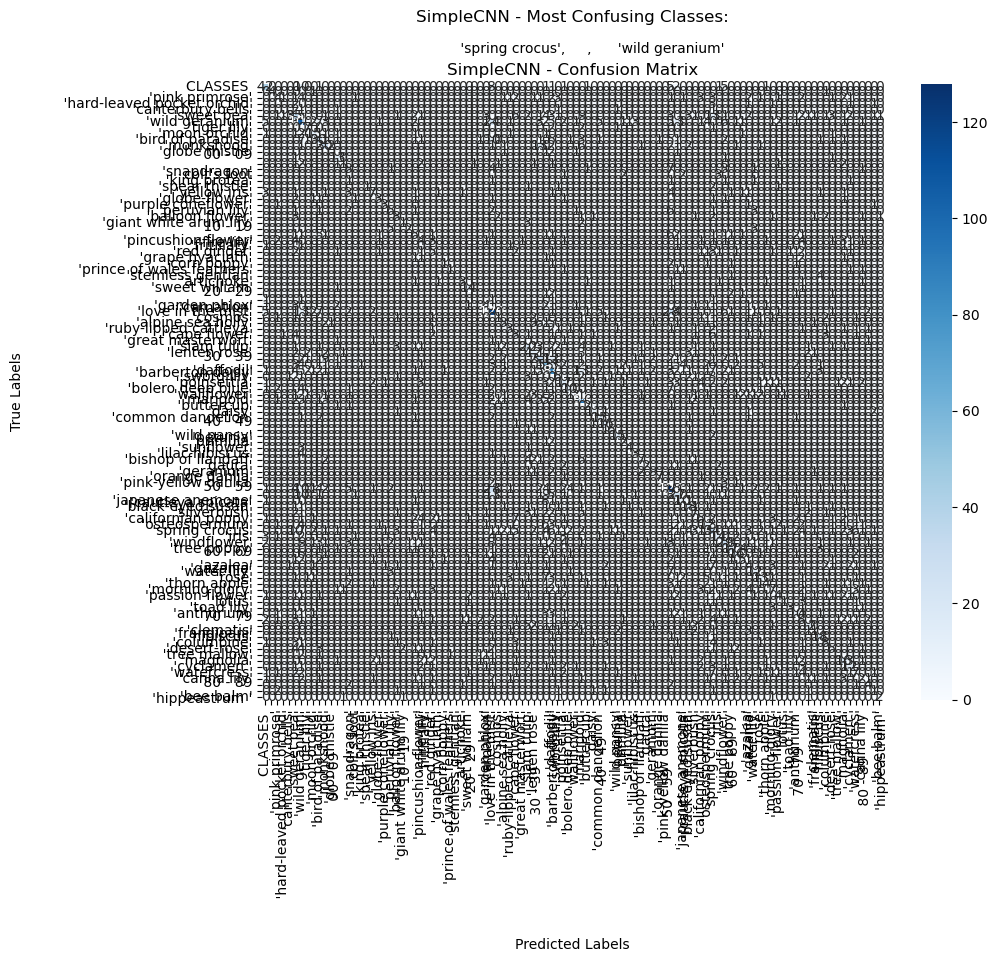

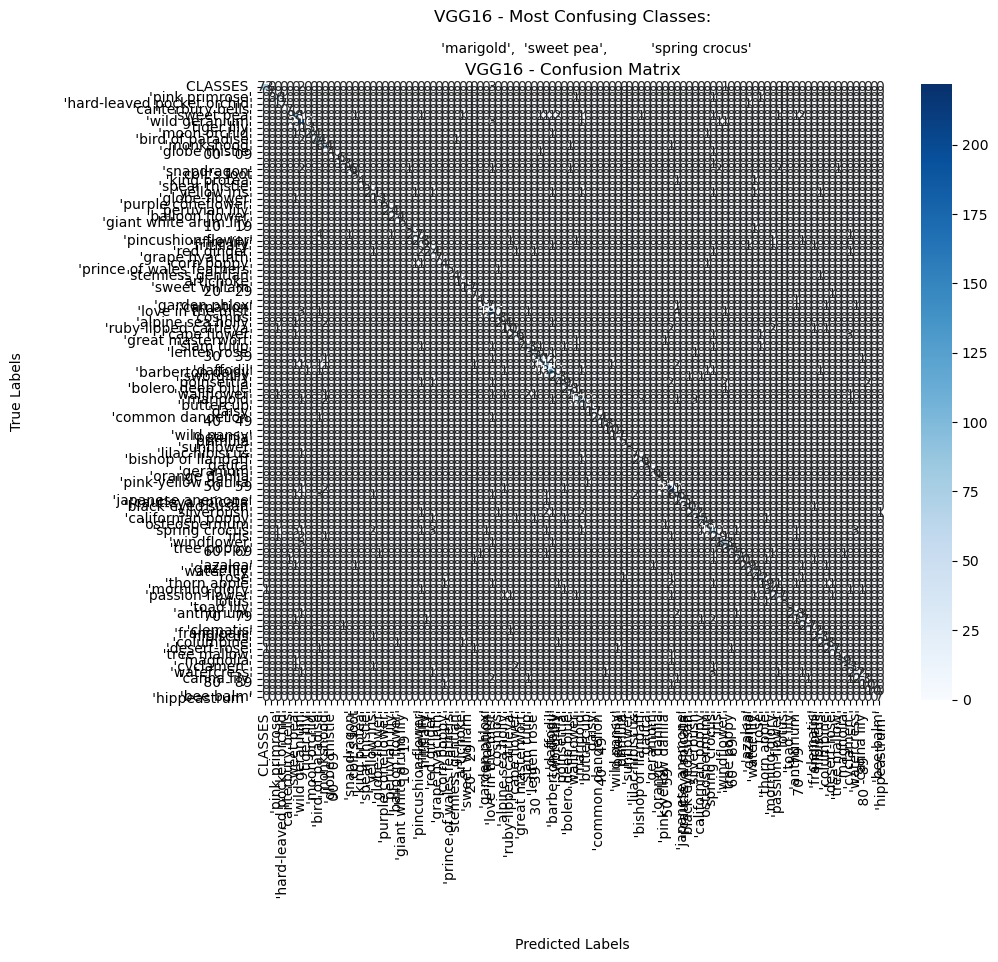

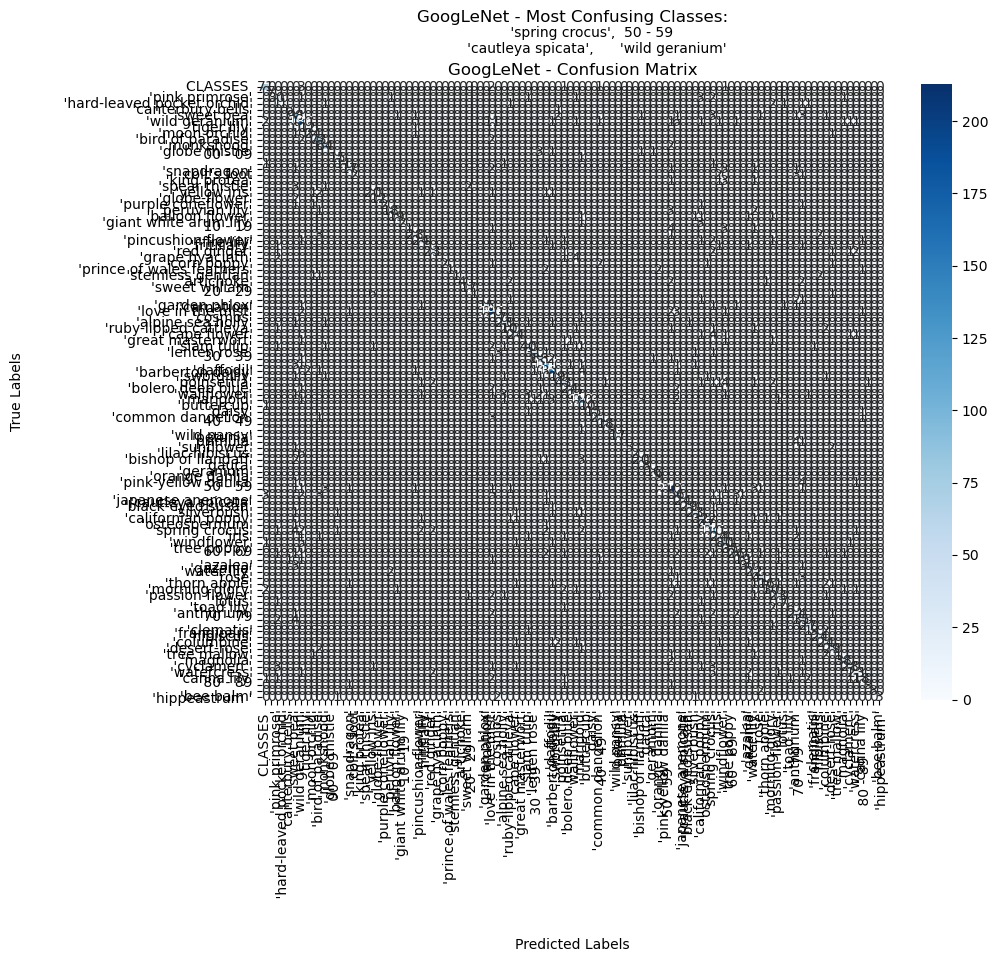

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Making a function to plot the confusion matrix with model name and most confusing classes
def plot_confusion_matrix(model_name, y_true, y_pred, class_names, top_k):
    cm = confusion_matrix(y_true, y_pred)
    misclassified_counts = np.sum(cm - np.diag(np.diag(cm)), axis=1)
    most_confusing_indices = np.argsort(misclassified_counts)[-top_k:]
    most_confusing_classes = [class_names[i] for i in most_confusing_indices]

    plt.figure(figsize=(10, 8))
    plt.text(0.5, 1.1, f'{model_name} - Most Confusing Classes:', size=12, ha="center", transform=plt.gca().transAxes)
    plt.text(0.5, 1.05, f'{", ".join(most_confusing_classes)}', size=10, ha="center", transform=plt.gca().transAxes)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

# Plotting confusion matrix for each model
class_names = [class_names[i] for i in range(104)]
top_k = 3  # Number of most confusing classes to display

# Plotting confusion matrix for SimpleCNN
plot_confusion_matrix("SimpleCNN", y_true_simplecnn, y_pred_simplecnn, class_names, top_k)

# Plotting confusion matrix for VGG16
plot_confusion_matrix("VGG16", y_true_vgg, y_pred_vgg, class_names, top_k)

# Plotting confusion matrix for GoogLeNet
plot_confusion_matrix("GoogLeNet", y_true_googlenet, y_pred_googlenet, class_names, top_k)


## (5) Graphs for the Peformance results 

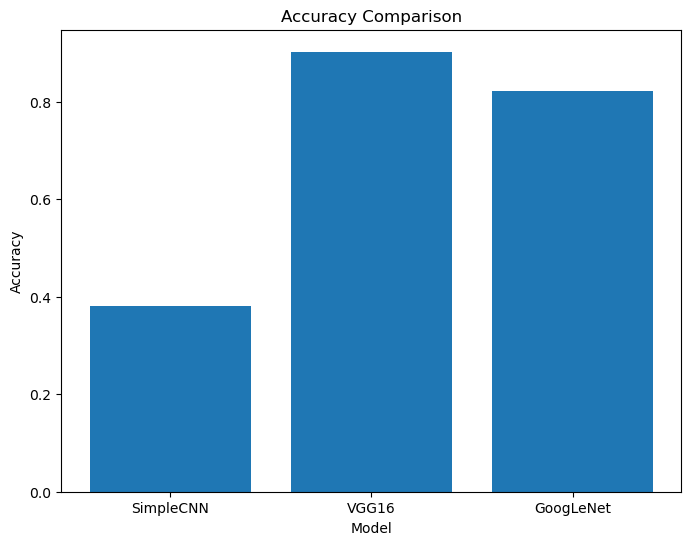

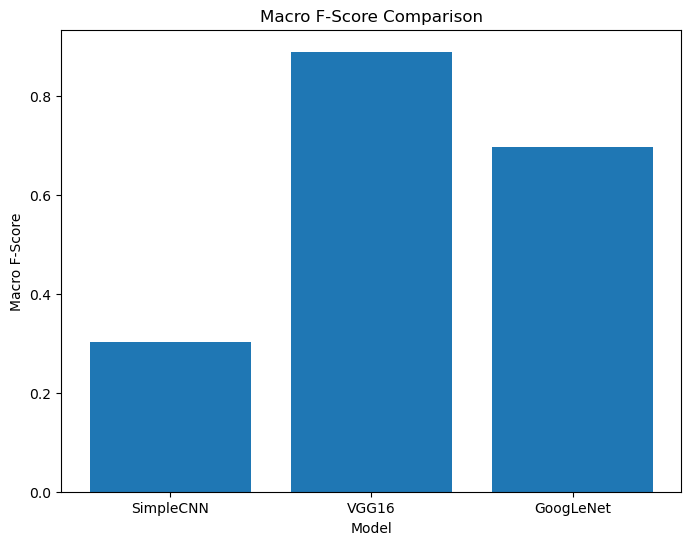

In [9]:
import matplotlib.pyplot as plt

model_names = ['SimpleCNN', 'VGG16', 'GoogLeNet']
accuracies = [accuracy_simplecnn, accuracy_vgg, accuracy_googlenet]
f1_scores = [f1_score_simplecnn, f1_score_vgg, f1_score_googlenet]

# Ploting the accuracy results
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

# Plotting the macro F-score results
plt.figure(figsize=(8, 6))
plt.bar(model_names, f1_scores)
plt.xlabel('Model')
plt.ylabel('Macro F-Score')
plt.title('Macro F-Score Comparison')
plt.show()


## Some Success and Failure Cases of the Models

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_with_images(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    images = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            images.extend(inputs.cpu().numpy())

    return y_true, y_pred, images

# Evaluating the SimpleCNN model
simplecnn_model.load_state_dict(torch.load('simple_cnn.pth'))
simplecnn_model.to(device)
y_true_simplecnn, y_pred_simplecnn, images_simplecnn = evaluate_model_with_images(simplecnn_model, test_loader)

# Evaluating the VGG16 model
vgg_model.load_state_dict(torch.load('fine_tuned_vgg16.pth'))
vgg_model.to(device)
y_true_vgg, y_pred_vgg, images_vgg = evaluate_model_with_images(vgg_model, test_loader)

# Evaluating the GoogLeNet model
googlenet_model.load_state_dict(torch.load('fine_tuned_googlenet.pth'))
googlenet_model.to(device)
y_true_googlenet, y_pred_googlenet, images_googlenet = evaluate_model_with_images(googlenet_model, test_loader)







## For the SimpleCNN Model

Success cases for SimpleCNN:


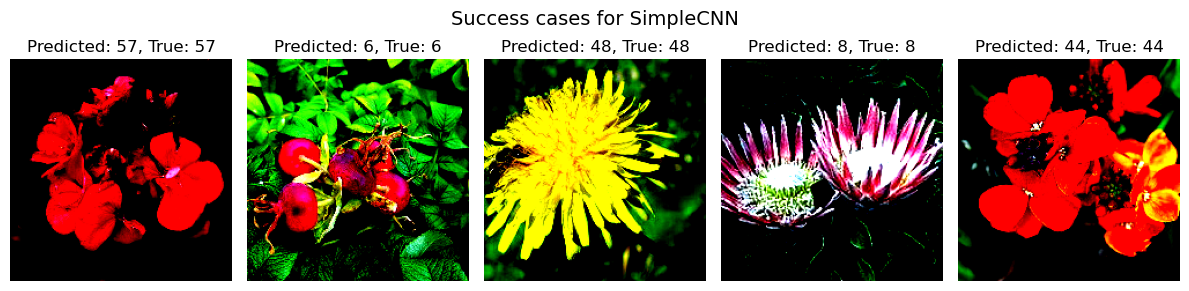


Failure cases for SimpleCNN:


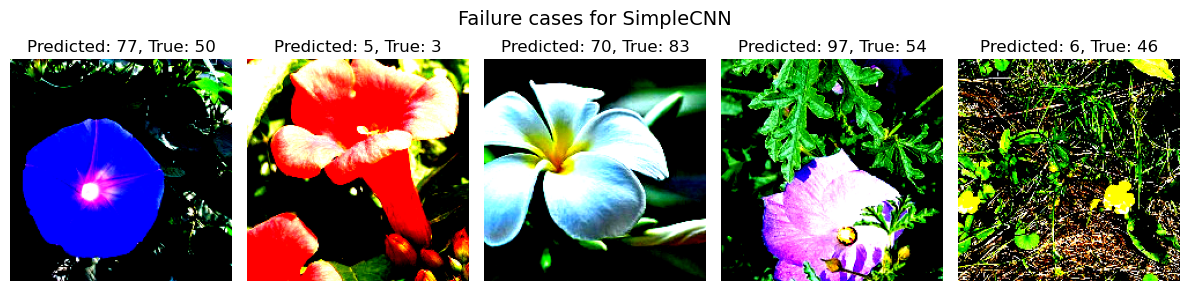

In [11]:
import random

model_name = "SimpleCNN"
correct_predictions = []
incorrect_predictions = []

for i in range(len(y_true_simplecnn)):
    if y_pred_simplecnn[i] == y_true_simplecnn[i]:
        correct_predictions.append(i)
    else:
        incorrect_predictions.append(i)

print(f"Success cases for {model_name}:")
success_cases = random.sample(correct_predictions, k=5)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
fig.suptitle(f"Success cases for {model_name}", fontsize=14)
for i, idx in enumerate(success_cases):
    predicted_label = y_pred_simplecnn[idx]
    true_label = y_true_simplecnn[idx]
    image = images_simplecnn[idx]

    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].set_title(f"Predicted: {predicted_label}, True: {true_label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"\nFailure cases for {model_name}:")
failure_cases = random.sample(incorrect_predictions, k=5)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
fig.suptitle(f"Failure cases for {model_name}", fontsize=14)
for i, idx in enumerate(failure_cases):
    predicted_label = y_pred_simplecnn[idx]
    true_label = y_true_simplecnn[idx]
    image = images_simplecnn[idx]

    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].set_title(f"Predicted: {predicted_label}, True: {true_label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## For the VGG Model

Success cases for VGG16:


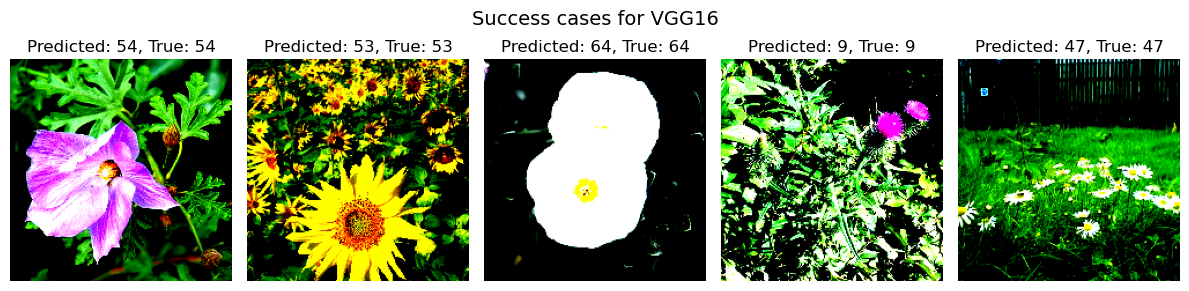


Failure cases for VGG16:


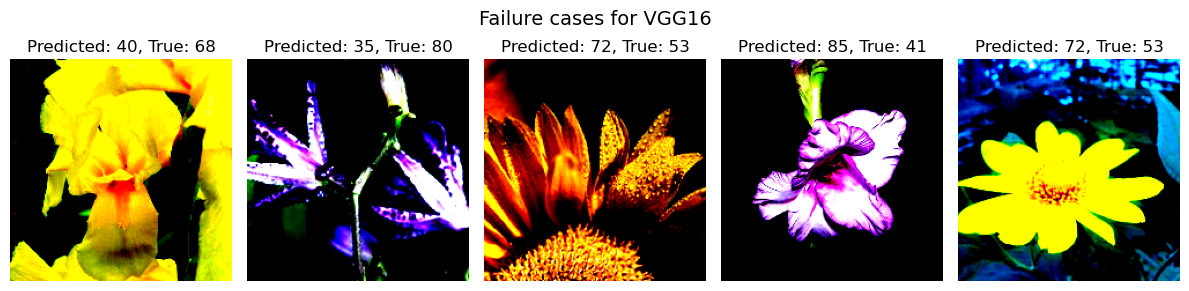

In [12]:
import random

model_name = "VGG16"
correct_predictions = []
incorrect_predictions = []

for i in range(len(y_true_vgg)):
    if y_pred_vgg[i] == y_true_vgg[i]:
        correct_predictions.append(i)
    else:
        incorrect_predictions.append(i)

print(f"Success cases for {model_name}:")
success_cases = random.sample(correct_predictions, k=5)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
fig.suptitle(f"Success cases for {model_name}", fontsize=14)
for i, idx in enumerate(success_cases):
    predicted_label = y_pred_vgg[idx]
    true_label = y_true_vgg[idx]
    image = images_vgg[idx]

    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].set_title(f"Predicted: {predicted_label}, True: {true_label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"\nFailure cases for {model_name}:")
failure_cases = random.sample(incorrect_predictions, k=5)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
fig.suptitle(f"Failure cases for {model_name}", fontsize=14)
for i, idx in enumerate(failure_cases):
    predicted_label = y_pred_vgg[idx]
    true_label = y_true_vgg[idx]
    image = images_vgg[idx]

    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].set_title(f"Predicted: {predicted_label}, True: {true_label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## For the GoogLeNet 

Success cases for GoogLeNet:


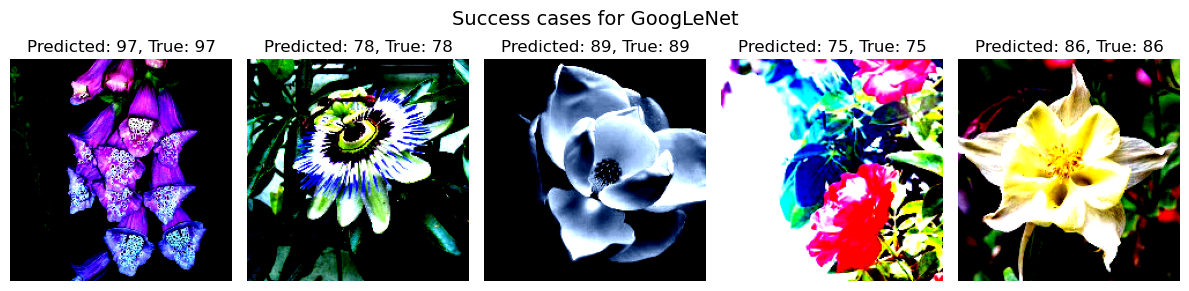


Failure cases for GoogLeNet:


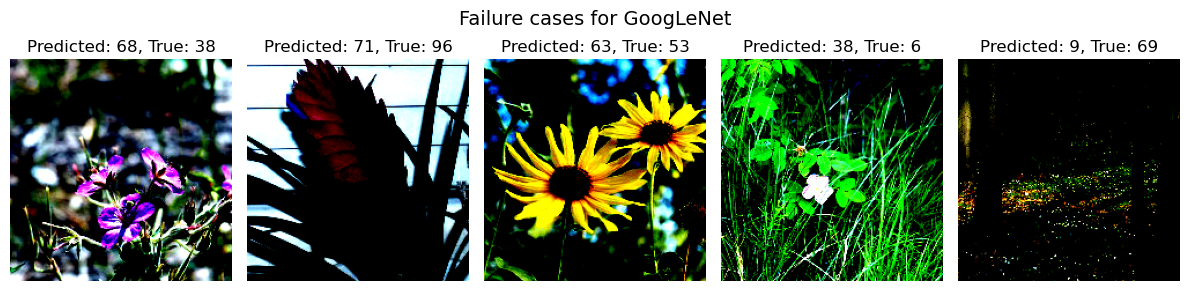

In [13]:
import random

model_name = "GoogLeNet"
correct_predictions = []
incorrect_predictions = []

for i in range(len(y_true_googlenet)):
    if y_pred_googlenet[i] == y_true_googlenet[i]:
        correct_predictions.append(i)
    else:
        incorrect_predictions.append(i)

print(f"Success cases for {model_name}:")
success_cases = random.sample(correct_predictions, k=5)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
fig.suptitle(f"Success cases for {model_name}", fontsize=14)
for i, idx in enumerate(success_cases):
    predicted_label = y_pred_googlenet[idx]
    true_label = y_true_googlenet[idx]
    image = images_googlenet[idx]

    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].set_title(f"Predicted: {predicted_label}, True: {true_label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

print(f"\nFailure cases for {model_name}:")
failure_cases = random.sample(incorrect_predictions, k=5)
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
fig.suptitle(f"Failure cases for {model_name}", fontsize=14)
for i, idx in enumerate(failure_cases):
    predicted_label = y_pred_googlenet[idx]
    true_label = y_true_googlenet[idx]
    image = images_googlenet[idx]

    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].set_title(f"Predicted: {predicted_label}, True: {true_label}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()
